In [1]:
import sys
from tqdm import tqdm
sys.path.append('..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from data.energy_data import EnergyDataset
from models.lstm import LSTM

In [2]:
timeseries = pd.read_csv('../data/data_preprocessed.csv')
timeseries = timeseries[['_value']]

In [6]:
train_dataset = EnergyDataset('../data/train.csv', window_size=96, predict_window=96)
test_dataset = EnergyDataset('../data/test.csv', window_size=96, predict_window=96)

train_loader = DataLoader(train_dataset, batch_size=16, drop_last=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, drop_last=True, shuffle=False)

X_train, y_train = train_dataset.return_X_y()
X_test, y_test = test_dataset.return_X_y()

In [7]:
model = LSTM(input_size=1, hidden_size=50, num_layers=1, output_size=1)
optimizer = optim.Adam(model.parameters())
loss_function = nn.MSELoss()

In [8]:
n_epochs = 100

train_progress = []
test_progress = []

for i in range(n_epochs):
    model.train()
    for x_batch, y_batch in tqdm(train_loader):
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    if i % 10 == 0:
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train)
            y_pred_test = model(X_test)
            train_rmse = np.sqrt(loss_function(y_pred_train, y_train).item())
            test_rmse = np.sqrt(loss_function(y_pred_test, y_test).item())
            train_progress.append(train_rmse)
            test_progress.append(test_rmse)
            
            print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (i, train_rmse, test_rmse))


100%|██████████| 1688/1688 [00:17<00:00, 98.76it/s] 


Epoch 0: train RMSE 0.1599, test RMSE 0.1268


100%|██████████| 1688/1688 [00:16<00:00, 103.79it/s]


Epoch 10: train RMSE 0.1493, test RMSE 0.1306


100%|██████████| 1688/1688 [00:16<00:00, 102.83it/s]


Epoch 20: train RMSE 0.1378, test RMSE 0.1363


100%|██████████| 1688/1688 [00:17<00:00, 98.57it/s] 


Epoch 30: train RMSE 0.1321, test RMSE 0.1409


100%|██████████| 1688/1688 [00:16<00:00, 102.93it/s]


Epoch 40: train RMSE 0.1264, test RMSE 0.1414


100%|██████████| 1688/1688 [00:15<00:00, 108.30it/s]


Epoch 50: train RMSE 0.1239, test RMSE 0.1465


100%|██████████| 1688/1688 [00:16<00:00, 103.10it/s]


Epoch 60: train RMSE 0.1182, test RMSE 0.1467


100%|██████████| 1688/1688 [00:16<00:00, 101.31it/s]


Epoch 70: train RMSE 0.1166, test RMSE 0.1444


100%|██████████| 1688/1688 [00:16<00:00, 104.21it/s]


Epoch 80: train RMSE 0.1144, test RMSE 0.1465


100%|██████████| 1688/1688 [00:17<00:00, 93.88it/s] 


Epoch 90: train RMSE 0.1136, test RMSE 0.1459


100%|██████████| 1688/1688 [00:16<00:00, 104.88it/s]


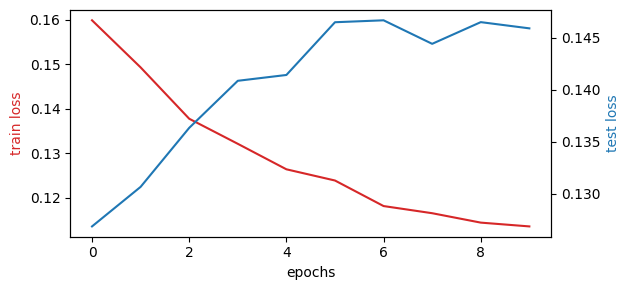

In [22]:
fig, ax1 = plt.subplots()
fig.set_figheight(3)

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('train loss', color=color)
ax1.plot(train_progress, color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('test loss', color=color)  # we already handled the x-label with ax1
ax2.plot(test_progress, color=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [10]:
# define offset / window size for plotting
offset = 96

with torch.no_grad():
    # shift train predictions for plotting
    y_pred_train = model(X_train)[:,-1,:]
    y_pred_test = model(X_test)[:,-1,:]

print(y_pred_train.shape, y_pred_test.shape, y_pred_test.shape[0] + y_pred_train.shape[0])

torch.Size([27014, 1]) torch.Size([6610, 1]) 33624


In [11]:
model(X_test).shape

torch.Size([6610, 96, 1])

In [12]:
y_pred = torch.cat([y_pred_train, y_pred_test], dim=0)
y_pred.shape

torch.Size([33624, 1])

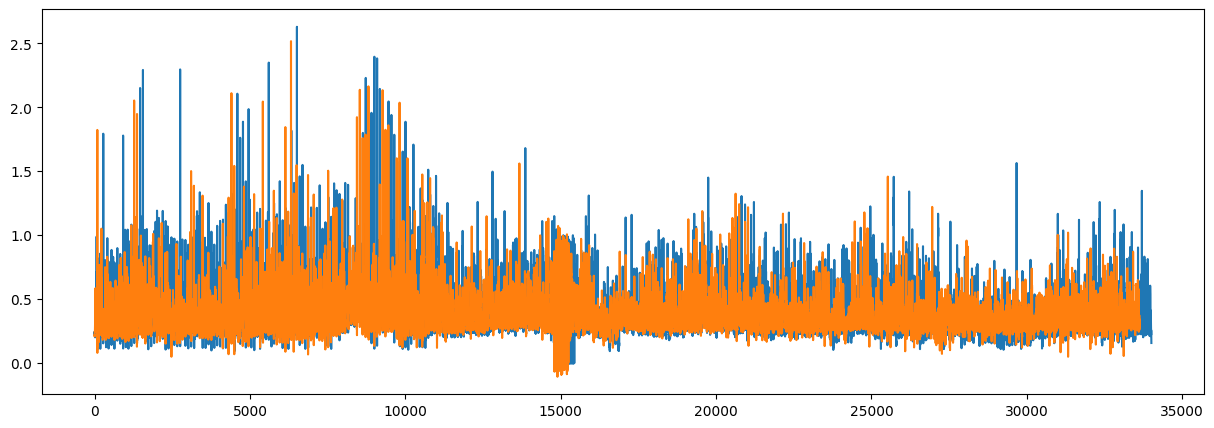

In [13]:
plt.figure(figsize=(15,5))

plt.plot(timeseries)
plt.plot(y_pred)

In [14]:
y_test = pd.read_csv('../data/test.csv')[['_value']]
y_train = pd.read_csv('../data/train.csv')[['_value']]

In [15]:
y_test = y_test[offset-1:].values.tolist()

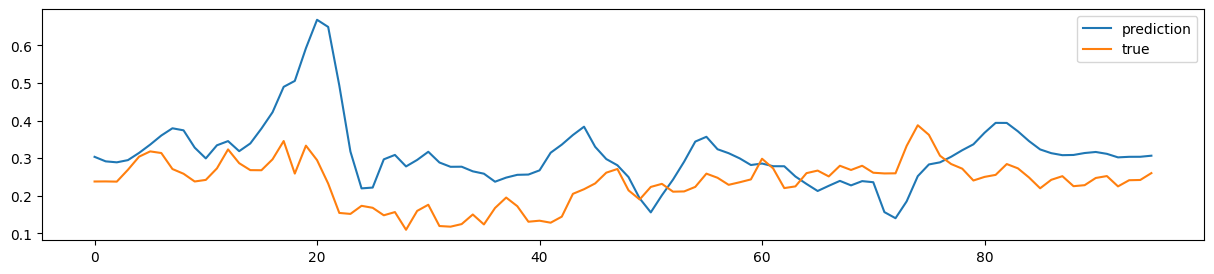

In [16]:
plt.figure(figsize=(15,3))
plt.plot(y_pred_test[:96], label='prediction')
plt.plot(y_test[:96], label='true')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), '../saved_models/lstm_w4.pt')